# Exploratory Topic Modeling

## Introduction

### Summary
In this notebook, I'm going to try to build a topic model using [legislation proposed in Maryland in 2018](). 

I heavily relied on a [Topic Modeling tutorial I found on MachineLearningPlus](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/). Thanks to everyone in the community who is putting out information to help others learn!

### Gathering the data

I built a web scraper that crawls the [Maryland General Assembly's website](http://mgaleg.maryland.gov/webmga/frmLegislation.aspx?pid=legisnpage&tab=subject3) and collects information about each bill proposed in the 2018 session. To build the topic model, I used the "Purpose" from each bill; this was a really interesting challenge! If you're interested on my approach, you can read through my tutorial [here]().

### Requirements

You can download the entire project on my GitHub, but if you want to walk through this yourself, be sure you have the following packages:

* pandas
* gensim
* spacy
* sklearn

## Data Preparation

### Loading in the data

As I mentioned above, I've already collected the data myself. If you're interested in learning more about that, you can look [here]().


In [1]:
import pandas as pd

data = pd.read_csv(
    'C:\\Users\\switkowski\\Documents\\Projects\\Topic-Model-MD-Legislation\\legislation_scraper\\data\\bill_data.csv')
data.head(1)

,bill_name,bill_number,broad_subjects,committee,narrow_subjects,purpose,sponsor,status,url
0,Harford County Sheriff - Deputy Sheriffs and C...,HB0015,Courts and Court Personnel - Local,Appropriations,"Collective Bargaining,Contracts -see also- Lan...",FOR the purpose of providing that certain depu...,Delegate Lisanti,In the House - Unfavorable Report by Appropria...,http://mgaleg.maryland.gov/2018RS/bills/hb/hb0...


There's a lot of information in this file. Briefly, here's what's contained in `bill_data.csv`.

* bill_name
* bill_number
* broad_subjects
* committee
* narrow_subjects
* purpose
* sponsor
* status
* url

To build the topic model, we're going to use `purpose`.

The first thing I'm going to do is convert `purpose` to a list.

In [2]:
purpose = data.purpose.tolist()

### Preparing and processing the text data

Next, I'm going to process the text a little bit. To accurately build the model, I need to standardize the text as uniform as possible.

First, I'm going to use `gensim.utils.simplepreprocess` to remove lowercases, accents, and [tokenize the data](https://www.techopedia.com/definition/13698/tokenization). Tokenizing the data converts out 

In [3]:
import gensim
from pprint import pprint

purpose_words = [gensim.utils.simple_preprocess(
    str(text), deacc=True) for text in purpose]

pprint(purpose_words[1])

C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


['for',
 'the',
 'purpose',
 'of',
 'authorizing',
 'the',
 'creation',
 'of',
 'state',
 'debt',
 'not',
 'to',
 'exceed',
 'the',
 'proceeds',
 'to',
 'be',
 'used',
 'as',
 'grant',
 'to',
 'the',
 'county',
 'executive',
 'and',
 'county',
 'council',
 'of',
 'howard',
 'county',
 'for',
 'certain',
 'development',
 'or',
 'improvement',
 'purposes',
 'providing',
 'for',
 'disbursement',
 'of',
 'the',
 'loan',
 'proceeds',
 'subject',
 'to',
 'requirement',
 'that',
 'the',
 'grantee',
 'provide',
 'and',
 'expend',
 'matching',
 'fund',
 'establishing',
 'deadline',
 'for',
 'the',
 'encumbrance',
 'or',
 'expenditure',
 'of',
 'the',
 'loan',
 'proceeds',
 'and',
 'providing',
 'generally',
 'for',
 'the',
 'issuance',
 'and',
 'sale',
 'of',
 'bonds',
 'evidencing',
 'the',
 'loan',
 'section',
 'be',
 'it',
 'enacted']


The text looks a lot better now, but there's one more critical step I need to take before we can move forward. You'll notice that there are words that take both a singular and plural version in this text (for example, "purpose" and "purposes"). These are effectively conveying the same message, but they would be processed as different words. 

To improve my model, I'm going to take the [*lemma* of each word](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) using `spacy` and lemmatization. Using the example of "purpose" and "purposes", each word would be converted to "purpose".

In [4]:
import spacy


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for text in texts:
        doc = nlp(" ".join(text))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in [
                         '-PRON-'] else "" for token in doc if token.pos_ in allowed_postags]))
    return texts_out


nlp = spacy.load('en', disable=(['parser', 'ner']))
purpose_lemmatized = lemmatization(purpose_words)

C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\importlib\_bootstrap.py:205: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\importlib\_bootstrap.py:205: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [5]:
purpose_lemmatized[0]

'purpose provide certain deputy sheriff correctional officer office sheriff harford county have right organize negotiate harford county executive harford county sheriff regard certain wage employee health care premium share require right organize negotiate be conduct accordance certain provision harford county code otherwise provide act require term agreement regard certain wage employee health care premium share be set memorandum agreement enter sheriff county executive employee organization provide agreement regard certain wage employee health care premium share be not effective agreement be ratify sheriff county executive employee organization provide modification exist memorandum agreement be not valid certain circumstance require certain procedure set harford county code apply certain party be unable reach certain agreement provide construction act generally relate salary negotiation right swear law enforcement officer correctional officer harford county sheriff office'

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(analyzer = 'word',
                            min_df = 10,
                            stop_words = 'english',
                            lowercase = True,
                            token_pattern = '[a-zA-Z0-9]{3,}')

purpose_vectorized = vectorizer.fit_transform(purpose_lemmatized)

In [7]:
purpose_dense = purpose_vectorized.todense()

print("Sparcity: " + str(((purpose_dense > 0).sum()/purpose_dense.size)*100) + "%")

Sparcity: 2.43933850340896%


In [8]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

lda_model = LatentDirichletAllocation(n_components=8,
                                     max_iter=10,
                                     learning_method='online',
                                     random_state=100,
                                     batch_size=50,
                                     evaluate_every=-1,
                                     n_jobs=-1)

lda_output = lda_model.fit_transform(purpose_vectorized)

print(lda_model)

LatentDirichletAllocation(batch_size=50, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=8, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [9]:
print("Log Likelihood: ", lda_model.score(purpose_vectorized))

Log Likelihood:  -1263931.107496432


In [10]:
print("Perplexity: ", lda_model.perplexity(purpose_vectorized))

Perplexity:  256.1582111918381


In [11]:
pprint(lda_model.get_params())

{'batch_size': 50,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 8,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [23]:
from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [15, 20, 25, 30, 35, 40, 45],
                'learning_decay': [0.5, 0.7, 0.9]}

lda = LatentDirichletAllocation()

model = GridSearchCV(lda, param_grid = search_params)

model.fit(purpose_vectorized)

C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\decomposition\onli

C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\decomposition\onli

limit_output extension: Maximum message size of 10000 exceeded with 10166 characters

In [24]:
best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)

print("Best Log Likelihood Score: ", model.best_score_)

print("Model Perplexity: ", best_lda_model.perplexity(purpose_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 20}
Best Log Likelihood Score:  -455010.4559557604
Model Perplexity:  214.09926327061902


C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\switkowski\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


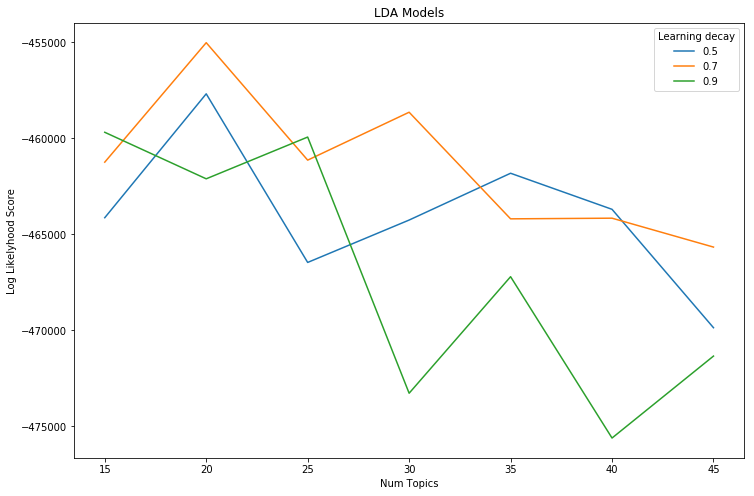

In [27]:
n_topics = [15, 20, 25, 30, 35, 40, 45]
log_likelyhoods_5 = [round(gscore.mean_validation_score)
                     for gscore in model.grid_scores_ if gscore.parameters['learning_decay'] == 0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score)
                     for gscore in model.grid_scores_ if gscore.parameters['learning_decay'] == 0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score)
                     for gscore in model.grid_scores_ if gscore.parameters['learning_decay'] == 0.9]

plt.figure(figsize = (12, 8))
plt.plot(n_topics, log_likelyhoods_5, label = '0.5')
plt.plot(n_topics, log_likelyhoods_7, label = '0.7')
plt.plot(n_topics, log_likelyhoods_9, label = '0.9')
plt.title('LDA Models')
plt.xlabel('Num Topics')
plt.ylabel('Log Likelyhood Score')
plt.legend(title = 'Learning decay', loc = 'best')
plt.show()

In [14]:
topic_keywords = pd.DataFrame(best_lda_model.components_)

topic_keywords.columns = vectorizer.get_feature_names()

topic_keywords.head()

,abandon,ability,absentee,abuse,academic,accept,access,accessible,accordance,account,...,work,worker,workforce,workgroup,write,writing,year,young,youth,zone
0,0.033343,0.033345,9.209560,0.033374,0.033344,7.873988,0.033346,0.033347,0.033439,0.033344,...,0.033343,0.033343,0.033344,0.033354,0.033357,0.033343,0.033344,11.123024,0.033344,0.033341
1,0.033343,3.106551,0.033343,0.033344,0.033344,0.034350,0.033395,0.033345,14.001202,0.033342,...,0.033377,0.033368,0.033361,0.033380,7.133877,0.033343,0.033363,0.033343,0.033343,0.033359
2,0.033345,0.033346,0.033343,0.033379,0.033344,0.033436,0.042591,2.703536,26.954348,0.033344,...,69.324761,0.033422,0.033341,0.033480,19.988300,0.033352,221.598864,0.033346,0.067143,0.033359
3,0.033343,0.033352,21.272939,0.033372,0.033357,0.033342,10.035929,7.942922,0.033361,0.033359,...,0.033345,0.033347,0.033343,0.033346,0.038060,0.035562,0.033346,0.033342,0.033343,0.033372
4,0.033342,0.033342,0.033343,0.033343,0.033344,0.033343,0.033343,0.033342,0.033343,0.033343,...,0.033343,0.033344,0.033342,0.033342,0.033344,0.033343,0.033344,0.033345,0.033343,0.033344


In [16]:
import numpy as np

def show_topics(vectorizer = vectorizer,
               lda_model = lda_model,
               n_words = 20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        topic_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(topic_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(lda_model = best_lda_model)

In [21]:
topic_keywords

[array(['medical', 'supplement', 'registration', 'section', 'state',
        'physician', 'business', 'article', 'applicant', 'code',
        'maryland', 'replacement', 'register', 'require', 'certification',
        'volume', 'purpose', 'cannabis', 'electronic', 'board'],
       dtype='<U14'),
 array(['general', 'federal', 'special', 'office', 'operating', 'state',
        'senate', 'amendment', 'maryland', 'submit', 'natural',
        'legislative', 'shall', 'propose', 'inspector', 'restrict',
        'assembly', 'resource', 'foundation', 'house'], dtype='<U14'),
 array(['certain', 'require', 'county', 'school', 'board', 'education',
        'purpose', 'provide', 'public', 'state', 'student', 'relate',
        'generally', 'establish', 'high', 'requirement', 'term', 'officer',
        'facility', 'year'], dtype='<U14'),
 array(['service', 'emergency', 'certain', 'benefit', 'computer',
        'utility', 'use', 'pharmacy', 'disability', 'company',
        'montgomery', 'water', 'produ